In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MT5ForConditionalGeneration, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from datasets import load_dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm 
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
from scipy.stats import gmean
from evaluate import load
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import evaluate
import torch
import time
import nltk
import numpy as np
import torch.nn.functional as F

nltk.download('wordnet')
bertscore = load("bertscore")

/Users/jinhyunpark/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jinhyunpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Define metrics

In [2]:
# jhpark: verified that this is a correct way to use this 
def calculate_rouge(true_sentence, predicted_sentence):
    # jhpark: rouge1/rouge2 (e.g. rouge1, rouge2): n-gram based scoring.
    # jhpark: rougeL: Longest common subsequence based scoring.
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, predicted_sentence)
    return scores

In [3]:
# jhpark: verified that this is a correct way to use this 
def calculate_bleu(true_tokens, predicted_tokens):
    '''
    * reference for smoothing: A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU, Boxing Chen and Collin Cherry (2014)
    * method1: Smoothing method 1: Add *epsilon* counts to precision with 0 counts.
    * https://www.nltk.org/_modules/nltk/translate/bleu_score.html for more details
    '''
    bleu_score = sentence_bleu(true_tokens, predicted_tokens, smoothing_function=SmoothingFunction().method1)
    return bleu_score

### Datasets

In [4]:
# english to X is only possible for T5
from datasets import load_dataset, load_from_disk

# ds_de_en = load_dataset("wmt/wmt14", "de-en")
# ds_fr_en = load_dataset("wmt/wmt15", "fr-en")
# ds_ro_en = load_dataset("wmt/wmt16", "ro-en")

# ds_de_en.save_to_disk("../wmt14_de_en")
# ds_fr_en.save_to_disk("../wmt15_fr_en")
# ds_ro_en.save_to_disk("../wmt16_ro_en")

ds_de_en = load_from_disk("../wmt14_de_en")
ds_fr_en = load_from_disk("../wmt15_fr_en")
ds_ro_en = load_from_disk("../wmt16_ro_en")

### Models

In [5]:
t5_tokenizer_small = AutoTokenizer.from_pretrained('t5-small')
t5_model_small = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
print("Done with small")

t5_tokenizer_base = AutoTokenizer.from_pretrained('t5-base')
t5_model_base = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
print("Done with base")

Done with small
Done with base


### Init

In [6]:
def calculate_probs_from_logits(logits):
    return F.softmax(logits, dim=-1)

def generate_output_with_probs(model, tokenizer, example, top_k=5):
    '''
    - High Kurtosis: An indicator that the data has heavy tails or outliers.
    - Low Kurtosis:  An indicator that the data has thin tails and lacks outliers.
    '''
    inputs = tokenizer.encode(example, return_tensors="pt")
    output_ids = model.generate(inputs, max_new_tokens=np.inf, return_dict_in_generate=True, output_scores=True, return_legacy_cache=False)
    output_tokens = output_ids.sequences[0]
    output_probs = []
    output_kurtosis = []

    # Retrieve probabilities for each token
    for i in range(1, len(output_tokens) - 1):  # Skip the first token and the last token
        # Fetch the logits from output_ids.scores, aligning with output_tokens[1:]
        probs = calculate_probs_from_logits(output_ids.scores[i - 1])[0]  # i-1 to align with `scores` index
        token_id = output_tokens[i]
        token_prob = probs[token_id].item()

        # Compute kurtosis on top probabilities
        top_probs, _ = torch.topk(probs, 1000)
        kurt = kurtosis(top_probs)

        output_probs.append(token_prob)
        output_kurtosis.append(kurt)
    
    decoded_output = tokenizer.decode(output_tokens, skip_special_tokens=True)
    return decoded_output, np.array(output_probs), np.array(output_kurtosis)

def visualization_1(token_probs, scaled_token_kurtosis):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(np.arange(0, len(token_probs)), token_probs, label='Token probability', c='red', marker='o')
    ax1.plot(np.arange(0, len(token_probs)), scaled_token_kurtosis, label='Token kurtosis', c='blue', marker='^')
    ax1.legend()

    model = LinearRegression()
    model.fit(token_probs.reshape(-1, 1), scaled_token_kurtosis)
    predictions = model.predict(token_probs.reshape(-1, 1))
    r2 = r2_score(scaled_token_kurtosis, predictions)
    ax2.scatter(token_probs, scaled_token_kurtosis, color='blue')
    ax2.plot(token_probs, predictions, color='red', label=f'Regression Line (R² = {r2:.2f})')
    ax2.legend()
    plt.show()

def visualization_2(score_collector_en_X):   
    # bleu
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.scatter(score_collector_en_X['bleu'], score_collector_en_X['Confidence-G-T'])
    ax2.scatter(score_collector_en_X['bleu'], score_collector_en_X['Confidence-A-T'])
    ax3.scatter(score_collector_en_X['bleu'], score_collector_en_X['Confidence-A-K'])
    ax1.set_ylabel('Confidence-G-T')
    ax2.set_ylabel('Confidence-A-T')
    ax3.set_ylabel('Confidence-A-K')
    ax1.set_xlabel('bleu')
    ax2.set_xlabel('bleu')
    ax3.set_xlabel('bleu')
    plt.plot()

    # meteor
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.scatter(score_collector_en_X['meteor'], score_collector_en_X['Confidence-G-T'])
    ax2.scatter(score_collector_en_X['meteor'], score_collector_en_X['Confidence-A-T'])
    ax3.scatter(score_collector_en_X['meteor'], score_collector_en_X['Confidence-A-K'])
    ax1.set_ylabel('Confidence-G-T')
    ax2.set_ylabel('Confidence-A-T')
    ax3.set_ylabel('Confidence-A-K')
    ax1.set_xlabel('meteor')
    ax2.set_xlabel('meteor')
    ax3.set_xlabel('meteor')
    plt.plot()

    # bert_f1s
    bert_f1s = []
    for i in range(samples):
        bert_f1 = score_collector_en_X['bert'][i]['f1']
        bert_f1s.append(bert_f1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.scatter(bert_f1s, score_collector_en_X['Confidence-G-T'])
    ax2.scatter(bert_f1s, score_collector_en_X['Confidence-A-T'])
    ax3.scatter(bert_f1s, score_collector_en_X['Confidence-A-K'])
    ax1.set_ylabel('Confidence-G-T')
    ax2.set_ylabel('Confidence-A-T')
    ax3.set_ylabel('Confidence-A-K')
    ax1.set_xlabel('bert_f1s')
    ax2.set_xlabel('bert_f1s')
    ax3.set_xlabel('bert_f1s')
    plt.plot()

    # rouge_1s 
    rouge_1s = []
    for i in range(samples):
        rouge_1 = score_collector_en_X['rouge'][i]['rouge1'].fmeasure
        rouge_1s.append(rouge_1)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.scatter(rouge_1s, score_collector_en_X['Confidence-G-T'])
    ax2.scatter(rouge_1s, score_collector_en_X['Confidence-A-T'])
    ax3.scatter(rouge_1s, score_collector_en_X['Confidence-A-K'])
    ax1.set_ylabel('Confidence-G-T')
    ax2.set_ylabel('Confidence-A-T')
    ax3.set_ylabel('Confidence-A-K')
    ax1.set_xlabel('rouge_1s')
    ax2.set_xlabel('rouge_1s')
    ax3.set_xlabel('rouge_1s')
    plt.plot()

    # rouge_2s
    rouge_2s = []
    for i in range(samples):
        rouge_2 = score_collector_en_X['rouge'][i]['rouge2'].fmeasure
        rouge_2s.append(rouge_2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.scatter(rouge_2s, score_collector_en_X['Confidence-G-T'])
    ax2.scatter(rouge_2s, score_collector_en_X['Confidence-A-T'])
    ax3.scatter(rouge_2s, score_collector_en_X['Confidence-A-K'])
    ax1.set_ylabel('Confidence-G-T')
    ax2.set_ylabel('Confidence-A-T')
    ax3.set_ylabel('Confidence-A-K')
    ax1.set_xlabel('rouge_2s')
    ax2.set_xlabel('rouge_2s')
    ax3.set_xlabel('rouge_2s')
    plt.plot()

    # rouge_Ls
    rouge_Ls = []
    for i in range(samples):
        rouge_L = score_collector_en_X['rouge'][i]['rougeL'].fmeasure
        rouge_Ls.append(rouge_L)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ax1.scatter(rouge_Ls, score_collector_en_X['Confidence-G-T'])
    ax2.scatter(rouge_Ls, score_collector_en_X['Confidence-A-T'])
    ax3.scatter(rouge_Ls, score_collector_en_X['Confidence-A-K'])
    ax1.set_ylabel('Confidence-G-T')
    ax2.set_ylabel('Confidence-A-T')
    ax3.set_ylabel('Confidence-A-K')
    ax1.set_xlabel('rouge_Ls')
    ax2.set_xlabel('rouge_Ls')
    ax3.set_xlabel('rouge_Ls')
    plt.plot()

score_collector_en_de = {'bleu':[], 'meteor':[], 'rouge':[], 'bert':[], 'Confidence-G-T':[], 'Confidence-A-T':[], 'Confidence-A-K':[]}
score_collector_en_fr = {'bleu':[], 'meteor':[], 'rouge':[], 'bert':[], 'Confidence-G-T':[], 'Confidence-A-T':[], 'Confidence-A-K':[]}
score_collector_en_ro = {'bleu':[], 'meteor':[], 'rouge':[], 'bert':[], 'Confidence-G-T':[], 'Confidence-A-T':[], 'Confidence-A-K':[]}
samples = 100

### 1. Generate translations (English to German)

--------------- Sample 0 ---------------
[Sentences]
   Input: translate English to German: Resumption of the session
   True Translation: Wiederaufnahme der Sitzungsperiode
   Predicted Translation: Wiederaufnahme der Sitzungsperiode

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9993141289437586
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   [New UQ] Confidence-G-T (Geometric mean of token probability): 0.998
   [New UQ] Confidence-A-T (Arithmetic mean of token probability): 0.998
   [New UQ] Confidence-A-K (Arithmetic mean of kurtosis): 0.846
--------------- Sample 1 ---------------
[Sentences]
   Input: translate English to German: I declare resumed t

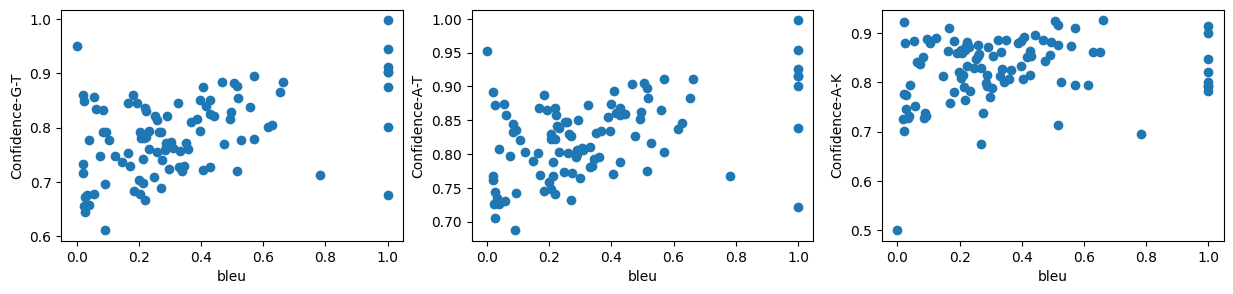

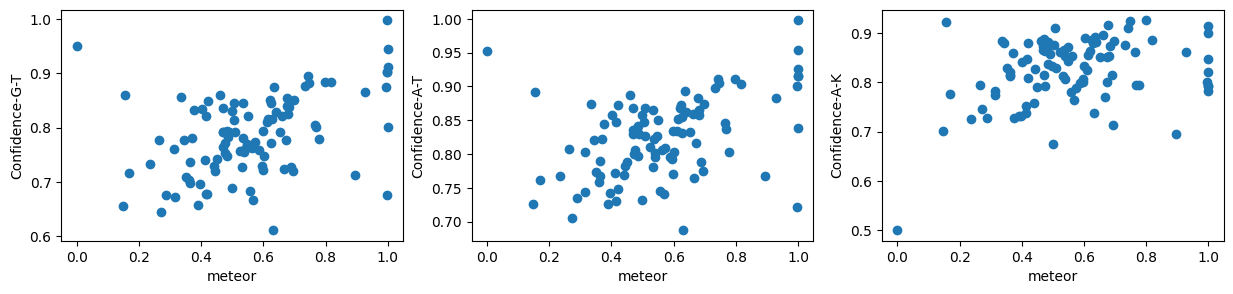

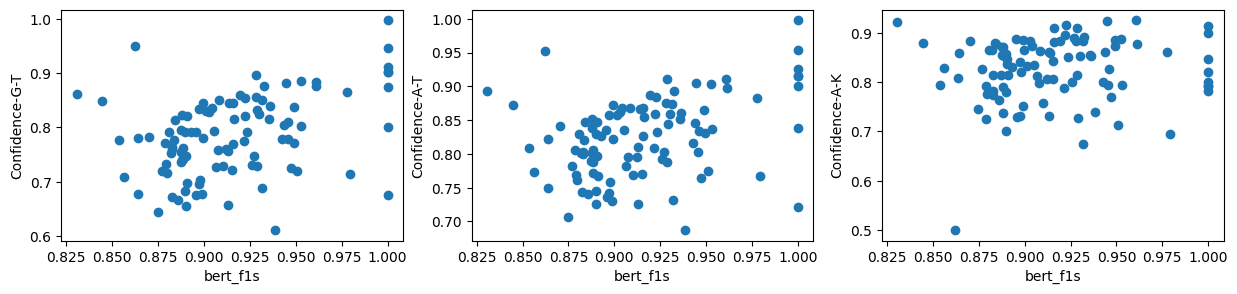

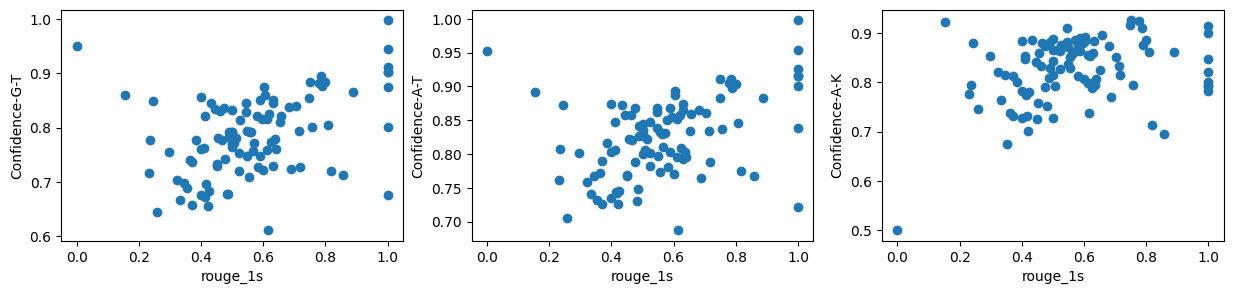

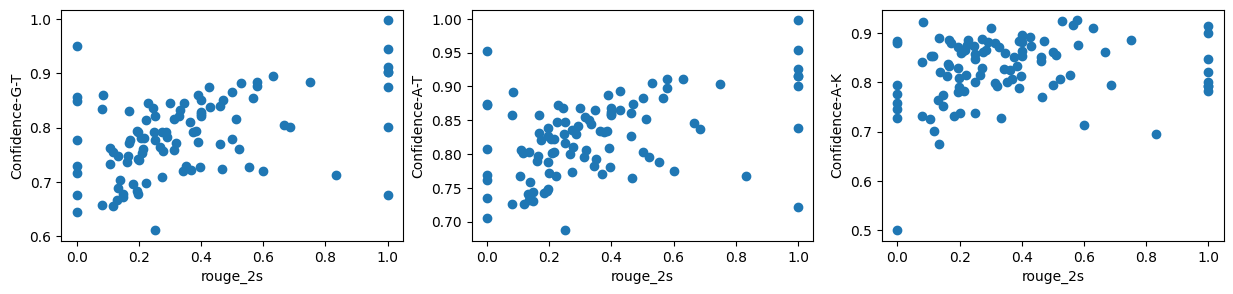

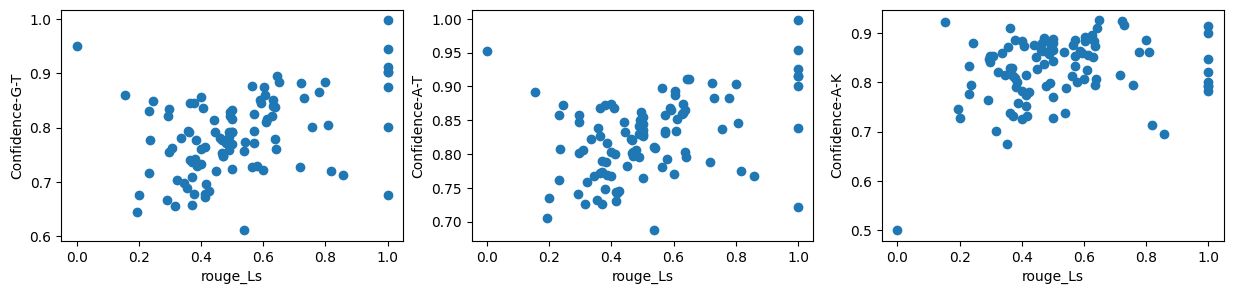

In [7]:
for i in range(samples):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to German: {ds_de_en['train'][i]['translation']['en']}"
    true_translation = ds_de_en['train'][i]['translation']['de']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # already available metrics
    bleu   = calculate_bleu([true_tokens], predicted_tokens)                                            # 1. BLEU
    meteor = meteor_score([true_tokens], predicted_tokens)                                              # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    rouge  = calculate_rouge(true_translation, predicted_translation)                                   # 3. ROUGE
    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   BLEU score:", bleu); score_collector_en_de['bleu'].append(bleu)
    print("   METEOR score:", meteor); score_collector_en_de['meteor'].append(meteor)
    print("   ROUGE score:", rouge); score_collector_en_de['rouge'].append(rouge)
    print("   BERT score:", bert); score_collector_en_de['bert'].append(bert)

    print("\n[Uncertainty Quantification]")
    print(f"   [New UQ] Confidence-G-T (Geometric mean of token probability): {np.round(gmean(token_probs), 3)}"); score_collector_en_de['Confidence-G-T'].append(gmean(token_probs))
    print(f"   [New UQ] Confidence-A-T (Arithmetic mean of token probability): {np.round(np.average(token_probs), 3)}"); score_collector_en_de['Confidence-A-T'].append(np.average(token_probs))
    print(f"   [New UQ] Confidence-A-K (Arithmetic mean of kurtosis): {np.round(np.average(scaled_token_kurtosis), 3)}"); score_collector_en_de['Confidence-A-K'].append(np.average(scaled_token_kurtosis))
    
    # visualization_1(token_probs, scaled_token_kurtosis)

visualization_2(score_collector_en_de)


### 2. Generate translations (English to French)

--------------- Sample 0 ---------------
[Sentences]
   Input: translate English to French: Resumption of the session
   True Translation: Reprise de la session
   Predicted Translation: Reprise de la session

[Scores]
   BLEU score: 1.0
   METEOR score: 0.996
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [0.9999998211860657], 'recall': [0.9999998211860657], 'f1': [0.9999998211860657], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   [New UQ] Confidence-G-T (Geometric mean of token probability): 0.95
   [New UQ] Confidence-A-T (Arithmetic mean of token probability): 0.954
   [New UQ] Confidence-A-K (Arithmetic mean of kurtosis): 0.8
--------------- Sample 1 ---------------
[Sentences]
   Input: translate English to French: I declare resume

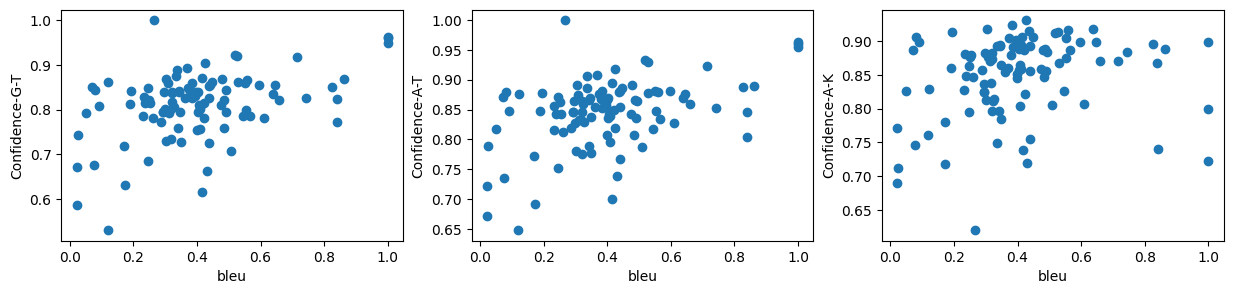

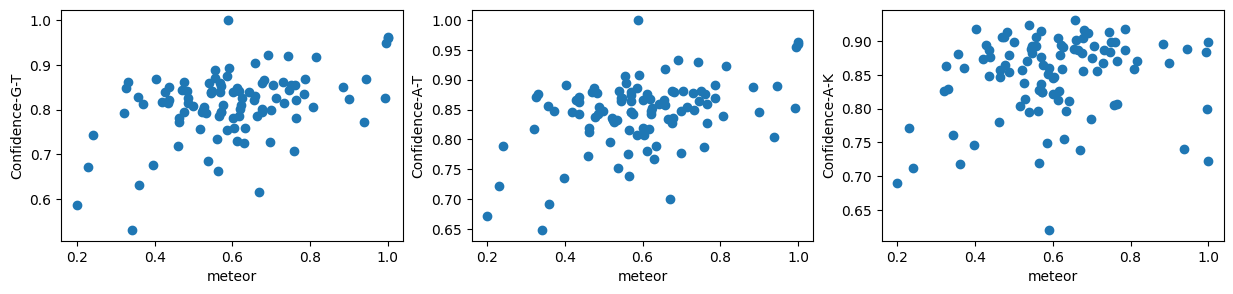

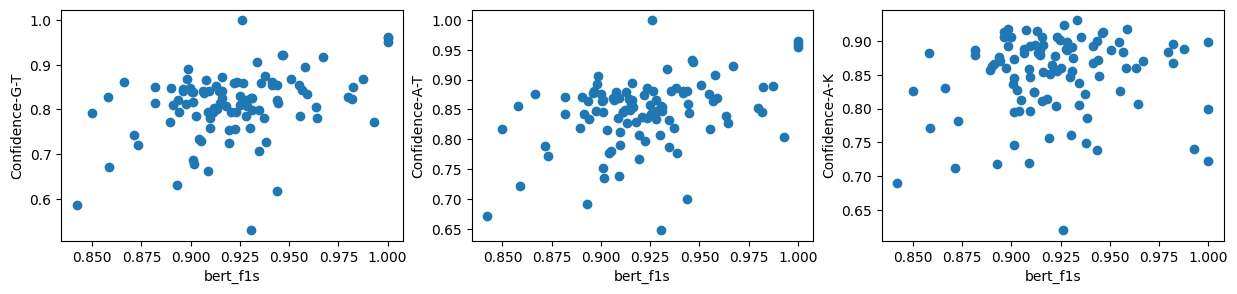

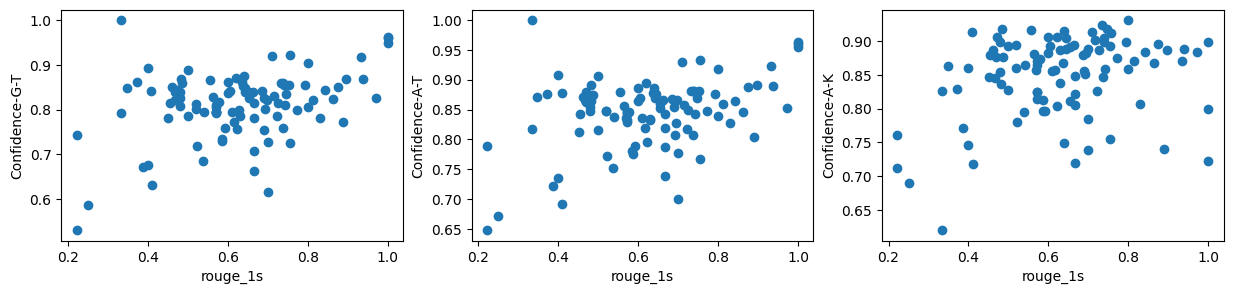

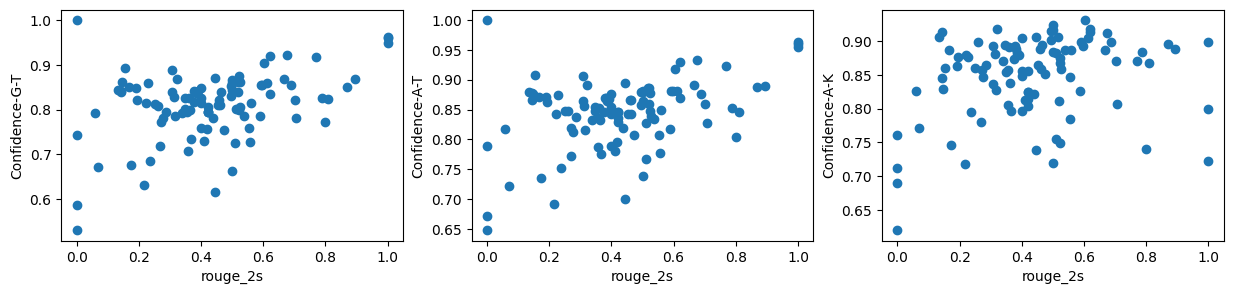

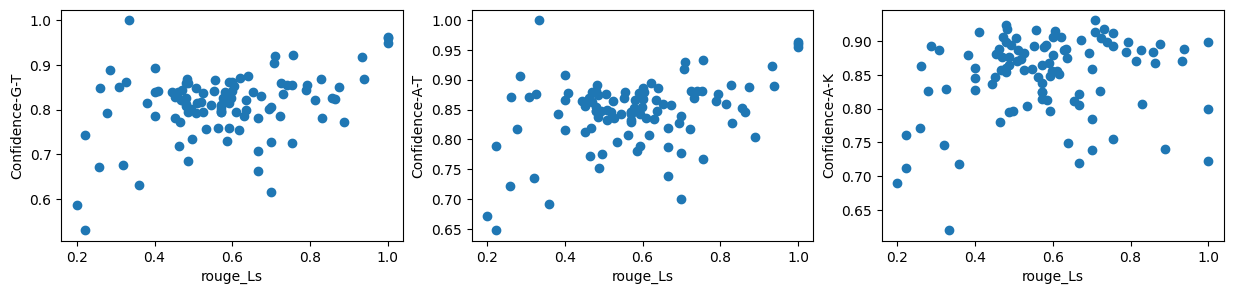

In [8]:
for i in range(samples):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to French: {ds_fr_en['train'][i]['translation']['en']}"
    true_translation = ds_fr_en['train'][i]['translation']['fr']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # already available metrics
    bleu   = calculate_bleu([true_tokens], predicted_tokens)                                            # 1. BLEU
    meteor = meteor_score([true_tokens], predicted_tokens)                                              # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    rouge  = calculate_rouge(true_translation, predicted_translation)                                   # 3. ROUGE
    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   BLEU score:", bleu); score_collector_en_fr['bleu'].append(bleu)
    print("   METEOR score:", meteor); score_collector_en_fr['meteor'].append(meteor)
    print("   ROUGE score:", rouge); score_collector_en_fr['rouge'].append(rouge)
    print("   BERT score:", bert); score_collector_en_fr['bert'].append(bert)

    print("\n[Uncertainty Quantification]")
    print(f"   [New UQ] Confidence-G-T (Geometric mean of token probability): {np.round(gmean(token_probs), 3)}"); score_collector_en_fr['Confidence-G-T'].append(gmean(token_probs))
    print(f"   [New UQ] Confidence-A-T (Arithmetic mean of token probability): {np.round(np.average(token_probs), 3)}"); score_collector_en_fr['Confidence-A-T'].append(np.average(token_probs))
    print(f"   [New UQ] Confidence-A-K (Arithmetic mean of kurtosis): {np.round(np.average(scaled_token_kurtosis), 3)}"); score_collector_en_fr['Confidence-A-K'].append(np.average(scaled_token_kurtosis))

    # visualization_1(token_probs, scaled_token_kurtosis)

visualization_2(score_collector_en_fr)


### 3. Generate translations (English to Romanian)

--------------- Sample 0 ---------------
[Sentences]
   Input: translate English to Romanian: Membership of Parliament: see Minutes
   True Translation: Componenţa Parlamentului: a se vedea procesul-verbal
   Predicted Translation: Componenţa Parlamentului: a se vedea procesul-verbal

[Scores]
   BLEU score: 1.0
   METEOR score: 0.9998177842565598
   ROUGE score: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
   BERT score: {'precision': [1.0], 'recall': [1.0], 'f1': [1.0], 'hashcode': 'distilbert-base-multilingual-cased_L5_no-idf_version=0.3.12(hug_trans=4.46.0)'}

[Uncertainty Quantification]
   [New UQ] Confidence-G-T (Geometric mean of token probability): 0.987
   [New UQ] Confidence-A-T (Arithmetic mean of token probability): 0.988
   [New UQ] Confidence-A-K (Arithmetic mean of kurtosis): 0.927
--------------- Sample 1 ---------------
[Sentences]
   Input

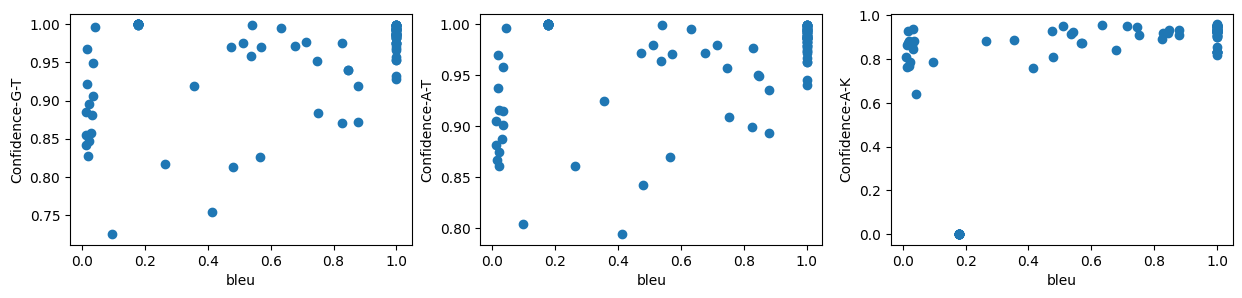

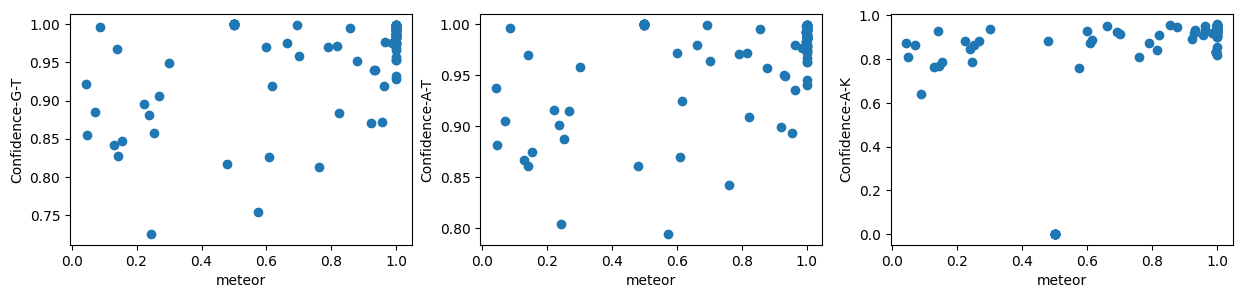

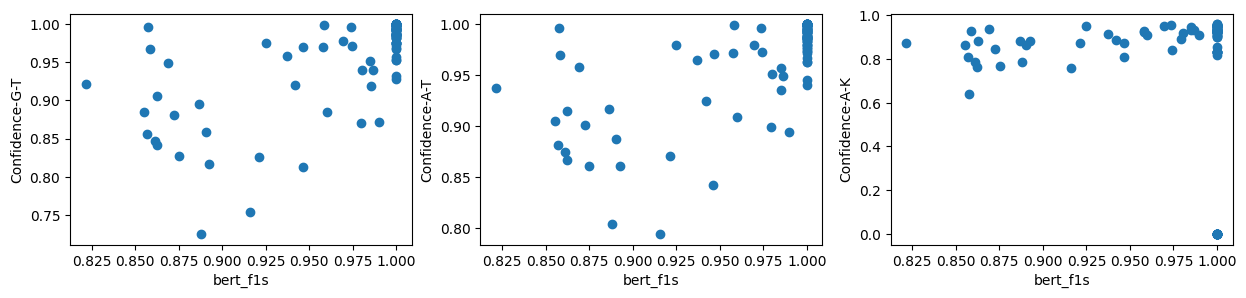

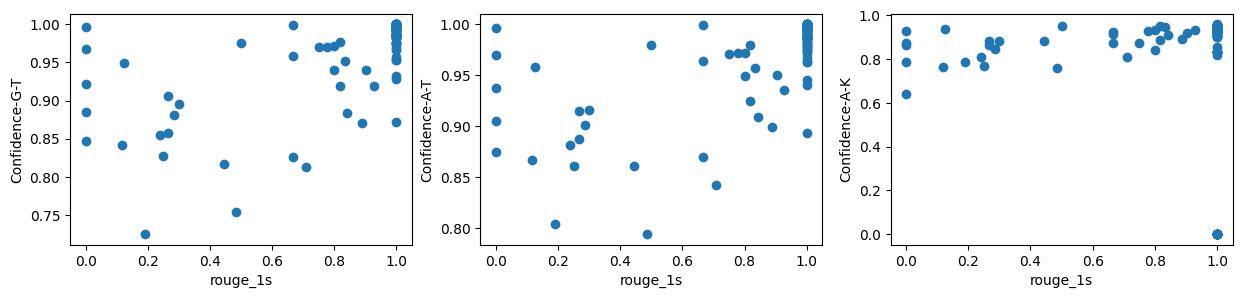

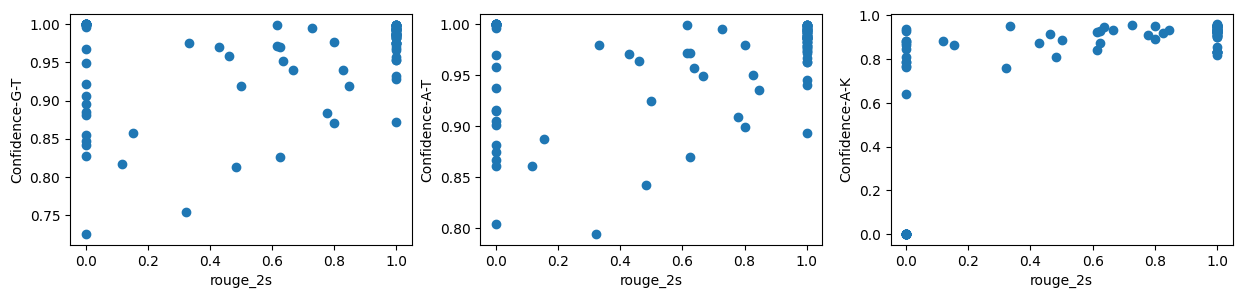

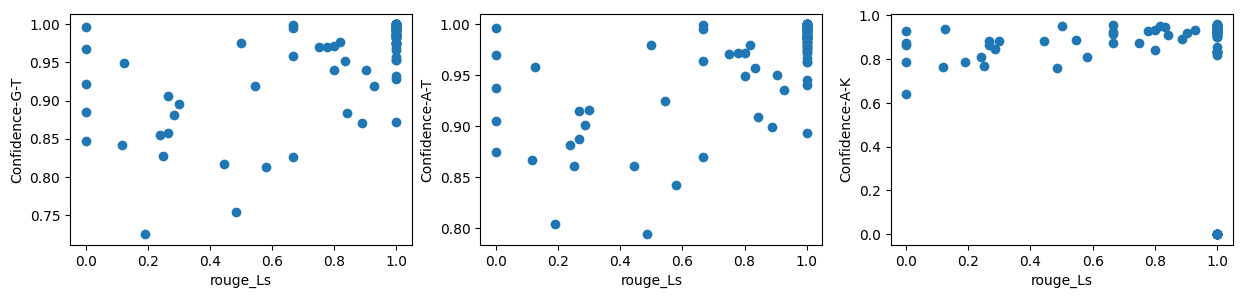

In [9]:
for i in range(samples):
    print(f"--------------- Sample {i} ---------------")
    input_text = f"translate English to Romanian: {ds_ro_en['train'][i]['translation']['en']}"
    true_translation = ds_ro_en['train'][i]['translation']['ro']
    predicted_translation, token_probs, token_kurtosis = generate_output_with_probs(model=t5_model_small, tokenizer=t5_tokenizer_small, example=input_text)

    # tokenize 
    true_tokens = t5_tokenizer_small.tokenize(true_translation)
    predicted_tokens = t5_tokenizer_small.tokenize(predicted_translation)

    # uncertainty quantification using kurtosis 
    token_kurtosis = token_kurtosis.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_token_kurtosis = scaler.fit_transform(token_kurtosis).flatten() 

    # already available metrics
    bleu   = calculate_bleu([true_tokens], predicted_tokens)                                            # 1. BLEU
    meteor = meteor_score([true_tokens], predicted_tokens)                                              # 2. METEOR (# jhpark: verified that this is a correct way to use this.)
    rouge  = calculate_rouge(true_translation, predicted_translation)                                   # 3. ROUGE
    bert = bertscore.compute(predictions=[predicted_translation], references=[true_translation], model_type='distilbert-base-multilingual-cased') # 4. BERTscore.

    # print results
    print("[Sentences]")
    print("   Input:", input_text)
    print("   True Translation:", true_translation)
    print("   Predicted Translation:", predicted_translation)

    print("\n[Scores]")
    print("   BLEU score:", bleu); score_collector_en_ro['bleu'].append(bleu)
    print("   METEOR score:", meteor); score_collector_en_ro['meteor'].append(meteor)
    print("   ROUGE score:", rouge); score_collector_en_ro['rouge'].append(rouge)
    print("   BERT score:", bert); score_collector_en_ro['bert'].append(bert)

    print("\n[Uncertainty Quantification]")
    print(f"   [New UQ] Confidence-G-T (Geometric mean of token probability): {np.round(gmean(token_probs), 3)}"); score_collector_en_ro['Confidence-G-T'].append(gmean(token_probs))
    print(f"   [New UQ] Confidence-A-T (Arithmetic mean of token probability): {np.round(np.average(token_probs), 3)}"); score_collector_en_ro['Confidence-A-T'].append(np.average(token_probs))
    print(f"   [New UQ] Confidence-A-K (Arithmetic mean of kurtosis): {np.round(np.average(scaled_token_kurtosis), 3)}"); score_collector_en_ro['Confidence-A-K'].append(np.average(scaled_token_kurtosis))

    # visualization_1(token_probs, scaled_token_kurtosis)

visualization_2(score_collector_en_ro)


The following metrics cannot be used because we only have one-to-one translations.

1. CIDEr: Consensus-based Image Description Evaluation
2. SPICE: Semantic Propositional Image Caption Evaluation